# Kalman Filtering

## Prediction Step

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [87]:
def createCovarianceEllipse(pos, cov):
    # https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix
    eig_values, eig_vectors = np.linalg.eig(cov)
    
    scale_95 = np.sqrt(5.991)
    radius_1 = scale_95 * eig_values[0]
    radius_2 = scale_95 * eig_values[1]
    angle = np.arctan2(eig_vectors[1, 1], eig_vectors[0, 1])
    
    #print("E-Values: ", eig_values)
    #print("E-Vectors: ", eig_vectors)
    #print("radius_1: ", radius_1)
    #print("radius_2: ", radius_2)
    #print("angle: ", angle)
    
    return radius_1, radius_2, angle

In [88]:
def getCorrelatedDataset(n, cov, mu, scale):
    # https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
    latent = np.random.randn(n, 2)
    cov = latent.dot(cov)
    scaled = cov * scale
    scaled_with_offset = scaled + mu
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]

In [89]:
def plotEllipse(ax, mu, radius_1, radius_2, angle, color):
    # https://matplotlib.org/stable/gallery/shapes_and_collections/ellipse_demo.html
    ellipse = Ellipse(
        mu,
        width=radius_1 * 2,
        height=radius_2 * 2,
        angle=np.rad2deg(angle) + 90,
        facecolor=color,
        alpha=0.4)

    ax.add_artist(ellipse)
    
    return ax

In [90]:
def plotData(ax, x, P, markersize, color, label):
    pos = x[0:2].reshape(2,)
    cov = P[0:2, 0:2]
    r1, r2, angle = createCovarianceEllipse(pos, cov)

    plotEllipse(ax, pos, r1, r2, angle, color)

    scale = 1, 1
    x, y = getCorrelatedDataset(300, cov, pos, scale)
    ax.scatter(x, y, s=markersize, c=color, label=label)

In [108]:
def example_prediction(title, x, P, F, Q):
    x_1 = F @ x_0
    P_1 = F @ P_0 @ F.T + Q

    print('x_1 = \n', x_1)
    print('\n')
    print('P_1 = \n', P_1)

    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'aspect': 'equal'})

    ax.set_title(title, fontsize=20, color='green', fontweight='bold')
    
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)

#     ax.set_xlim(-1, 4)
#     ax.set_ylim(-1.5, 1.5)

    ax.set_xlabel('position X (m)', fontweight ='bold')
    ax.set_ylabel('position Y (m)', fontweight ='bold')
       
    plotData(ax, x_0, P_0, 10, 'b', 'x_0 possibilities')
    plotData(ax, x_1, P_1, 10, 'r', 'x_1 possibilities')

    ax.scatter(x_0[0], x_0[1], s=100.0, marker='o', c='green', label='x_0 mean')
    ax.scatter(x_1[0], x_1[1], s=100.0, marker='o', c='purple', label='x_1 mean')

    plt.grid(visible=True)
    plt.legend(loc='upper right')
    plt.show()

### Example 1.A

We will assume that we know the initial position of the robot and also the velocity at that time.

$$
x_0 = \begin{bmatrix} p_X \\ p_y \\ v_x \\ v_y \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 2 \\ 0\end{bmatrix}
$$

Since the velocity along x-axis isn't zero, so one can expect that the robot will move by 2 units along x-axis at the next cycle, given that the sample time is 1 second $T = 1 sec$.

We can start guessing a value for the initial state covariance to be a very small value since we are confident about the initial position. And we will assume that the initial uncertainty of the velocities are much smaller compared to the position.

$$
P_0 = \begin{bmatrix} 0.1 & 0 & 0 & 0 \\ 0 & 0.1 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix}
$$

Additional, we will try the first exercise without adding any process noise $Q=0_{4 \times 4}$

We notice that the prdicted position is moved by 2 units in the x-direction because of the $v_x$ and the state covariance is not changed at all since we assumed that the prediction model is accurate (no process noise is added, $Q=0_{4 \times 4}$).

x_0 = 
 [[0.]
 [0.]
 [2.]
 [0.]]


P_0 = 
 [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]


x_1 = 
 [[2.]
 [0.]
 [2.]
 [0.]]


P_1 = 
 [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]


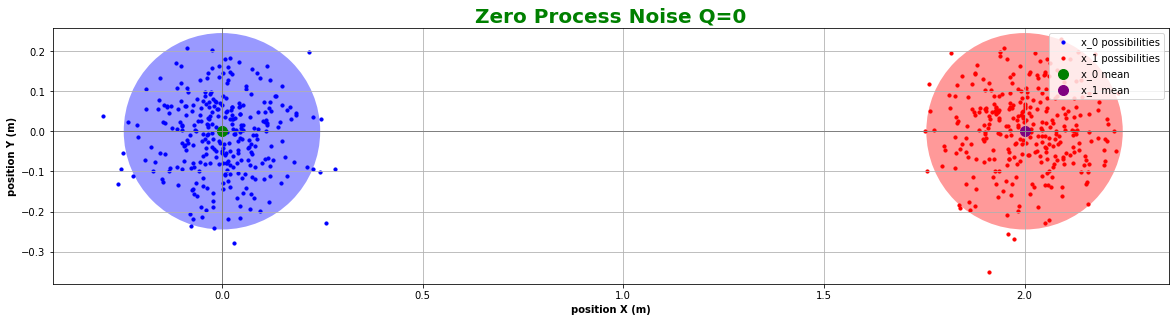

In [109]:
# Example (1)

# propagating the previous state through the state transition matrix F_k
T = 1.0 # sampling time = 1 sec

# build initial state vector and covariance
x_0 = np.array([[0.], [0.], [2.], [0.]]) # px, py, vx, vy

P_0 = np.zeros((4, 4))
P_0[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
P_0[2:4,2:4] = np.array([[0.0, 0.0], [0.0, 0.0]])

F = np.array([[1., 0., T, 0.],
              [0., 1., 0., T],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

Q = np.zeros((4, 4))

print('x_0 = \n', x_0)
print('\n')
print('P_0 = \n', P_0)
print('\n')

example_prediction('Zero Process Noise Q=0', x_0, P_0, F, Q)


### Example 1.B
Next, we try to give some uncertainty in our model by setting the process noise as explained before.

$$
Q_k' =
\begin{bmatrix}
    q_{11}T+q_{33}\frac{T^3}{3} & 0 & q_{33} \frac{T^2}{2} & 0 \\
    0 & q_{22}T+q_{44}\frac{T^3}{3} & 0 & q_{44} \frac{T^2}{2} \\
    q_{33} \frac{T^2}{2} & 0 & q_{33} T & 0 \\
    0 & q_{44} \frac{T^2}{2} & 0 & q_{44} T \\
\end{bmatrix}
$$

Then we set the values of $q_{11}$, $q_{22}$, $q_{33}$, and $q_{44}$ to $0.1$.

We notice that now the predicted state has wider uncertainty because we reduced the model accuracy by setting the process noise covariance $Q$.


x_1 = 
 [[2.]
 [0.]
 [2.]
 [0.]]


P_1 = 
 [[0.3  0.   0.15 0.  ]
 [0.   0.3  0.   0.15]
 [0.15 0.   0.3  0.  ]
 [0.   0.15 0.   0.3 ]]


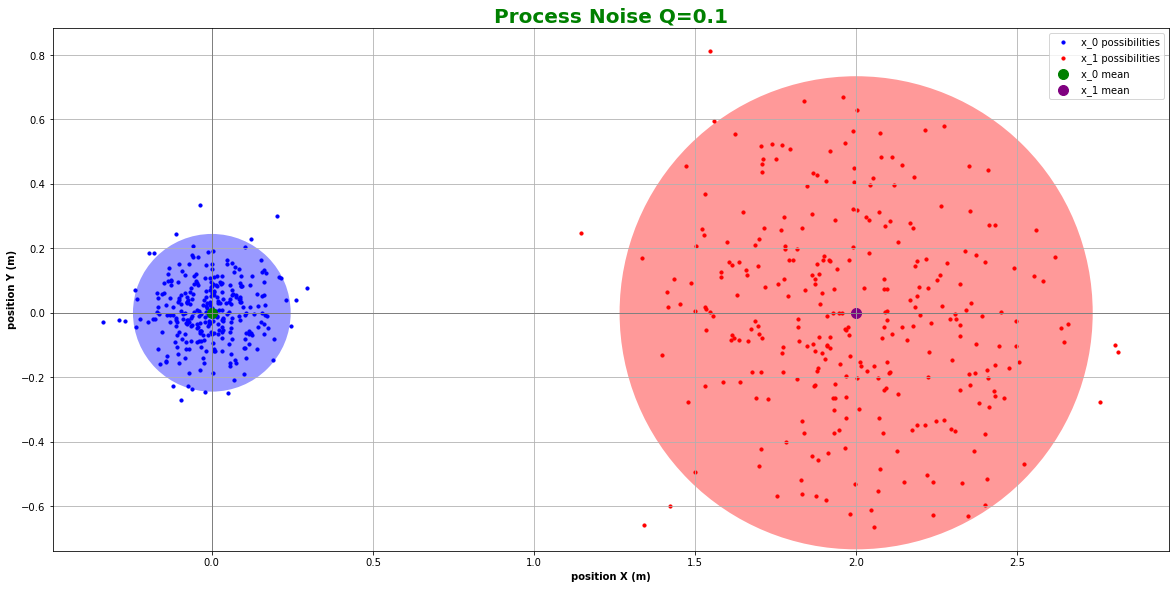

In [110]:
# propagating the previous state through the state transition matrix F_k
T = 1.0 # sampling time = 1 sec

# build initial state vector and covariance
x_0 = np.array([[0.], [0.], [2.], [0.]]) # px, py, vx, vy

P_0 = np.zeros((4, 4))
P_0[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
P_0[2:4,2:4] = np.array([[0.0, 0.0], [0.0, 0.0]])

F = np.array([[1., 0., T, 0.],
              [0., 1., 0., T],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

q_11 = 0.1
q_22 = 0.1
q_33 = 0.3
q_44 = 0.3

Q = np.array([[q_11 * T + q_33 * (T**3/3), 0., q_33 * (T**2/2), 0.],
              [0., q_22 * T + q_44 * (T**3/3), 0., q_44 * (T**2/2)],
              [q_33 * (T**2/2), 0., q_33 * T, 0.],
              [0., q_44 * (T**2/2), 0., q_44 * T]])

example_prediction('Process Noise Q=0.1', x_0, P_0, F, Q)

### Example 2

This example will be similar to Example 1.A but we will increase the initial uncertainty for the velocities while keeping process noise covariance zero $Q=0_{4 \times 4}$.

$$
P_0 = \begin{bmatrix} 0.1 & 0 & 0 & 0 \\ 0 & 0.1 & 0 & 0 \\ 0 & 0 & 0.1 & 0 \\ 0 & 0 & 0 & 0.1 \end{bmatrix}
$$

We find that the new predicted position has bigger uncertainty although we didn't add any process noise covariance. And this increase came from the correlation between the position and velocity as the uncertainty of the velocity is added up to the uncertainty of the position at the initial position resulting in more position uncertainty.

x_0 = 
 [[0.]
 [0.]
 [2.]
 [0.]]


P_0 = 
 [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.  0.1]]


x_1 = 
 [[2.]
 [0.]
 [2.]
 [0.]]


P_1 = 
 [[0.2 0.  0.1 0. ]
 [0.  0.2 0.  0.1]
 [0.1 0.  0.1 0. ]
 [0.  0.1 0.  0.1]]


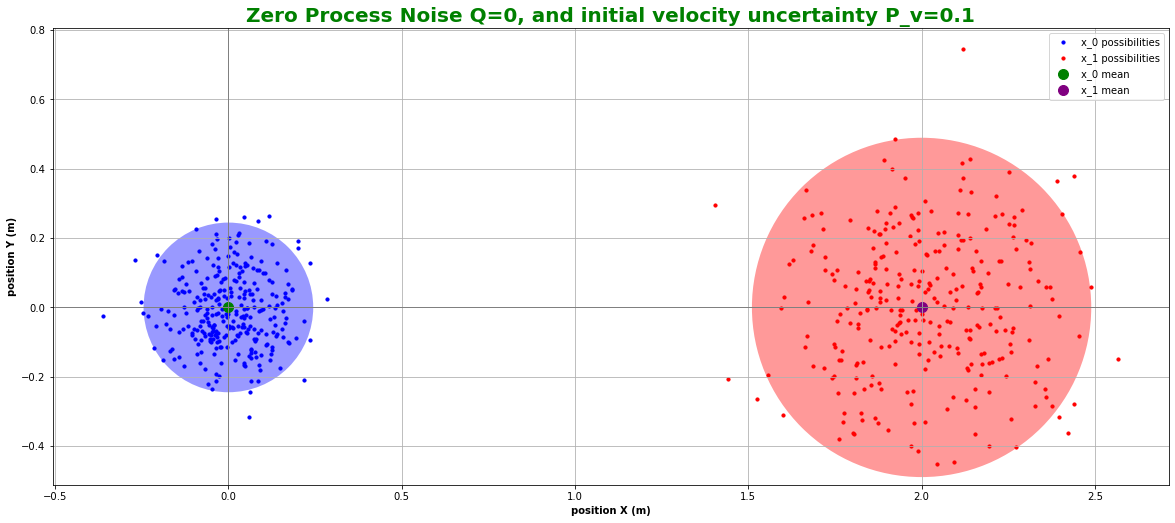

In [111]:
# Example (2)

# propagating the previous state through the state transition matrix F_k
T = 1.0 # sampling time = 1 sec

# build initial state vector and covariance
x_0 = np.array([[0.], [0.], [2.], [0.]]) # x, y, vx, vy

P_0 = np.zeros((4, 4))
P_0[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
P_0[2:4,2:4] = np.array([[0.1, 0.0], [0.0, 0.1]])

F = np.array([[1., 0., T, 0.],
              [0., 1., 0., T],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

Q = np.zeros((4, 4))

print('x_0 = \n', x_0)
print('\n')
print('P_0 = \n', P_0)
print('\n')

example_prediction('Zero Process Noise Q=0, and initial velocity uncertainty P_v=0.1', x_0, P_0, F, Q)

### Example 3

Now, we check what happen if we set the initial velocity in y-axis to an arbitrary value $v_y=1$ Such that:

$$
x_0 = \begin{bmatrix} p_X \\ p_y \\ v_x \\ v_y \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 2 \\ 1\end{bmatrix}
$$

We find that the new predicted position is moved along both x- and y-axis.

x_0 = 
 [[0.]
 [0.]
 [2.]
 [1.]]


P_0 = 
 [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.  0.1]]


x_1 = 
 [[2.]
 [1.]
 [2.]
 [1.]]


P_1 = 
 [[0.2 0.  0.1 0. ]
 [0.  0.2 0.  0.1]
 [0.1 0.  0.1 0. ]
 [0.  0.1 0.  0.1]]


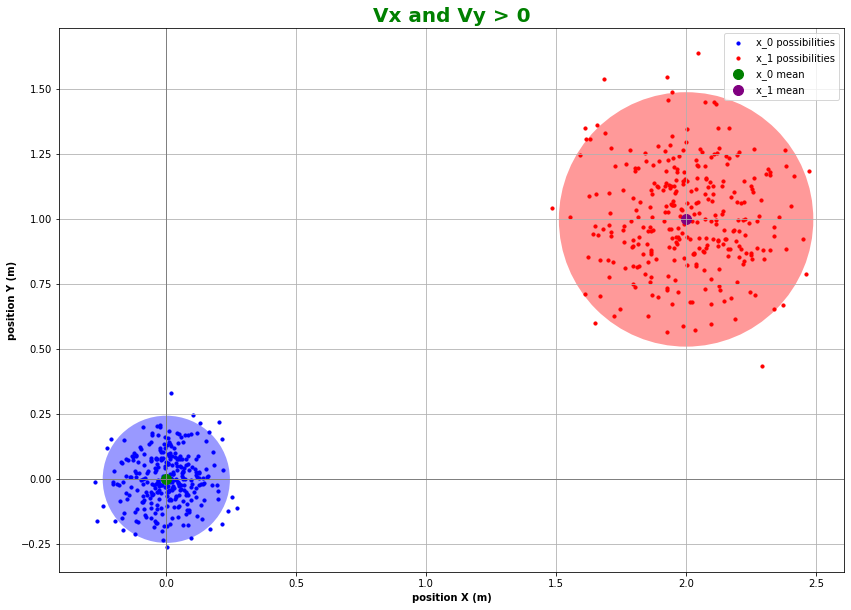

In [112]:
# Example (3)

# propagating the previous state through the state transition matrix F_k
T = 1.0 # sampling time = 1 sec

# build initial state vector and covariance
x_0 = np.array([[0.], [0.], [2.], [1.]]) # x, y, vx, vy

P_0 = np.zeros((4, 4))
P_0[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
P_0[2:4,2:4] = np.array([[0.1, 0.0], [0.0, 0.1]])

F = np.array([[1., 0., T, 0.],
              [0., 1., 0., T],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

Q = np.zeros((4, 4))

print('x_0 = \n', x_0)
print('\n')
print('P_0 = \n', P_0)
print('\n')

example_prediction('Vx and Vy > 0', x_0, P_0, F, Q)

### Covariance Visualization

Lets visualize the covariance in 2D and see how it changes in case there is a correlation and in case there is not.

This time we will make a 2D plot of $p_x$ (x-axis) and $v_x$ (y_axis) since the correlation are between these two elements in the state vector $x_k$.

In [113]:
def example_covariance(title, P):
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'aspect': 'equal'})

    ax.set_title(title, fontsize=20, color='green', fontweight='bold')
    
    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)

#     ax.set_xlim(-1, 1)
#     ax.set_ylim(-1, 1)

    ax.set_xlabel('position (m)', fontweight ='bold')
    ax.set_ylabel('velocity (m/s)', fontweight ='bold')
    
    x_0 = np.array([[0.], [0.]]) # x, y, vx, vy
    
    plotData(ax, x_0, P, 10, 'b', 'x_0 possibilities')

    ax.scatter(x_0[0], x_0[1], s=100.0, marker='o', c='green', label='x_0 mean')
    
    plt.grid(visible=True)
    plt.legend(loc='upper right')
    plt.show()

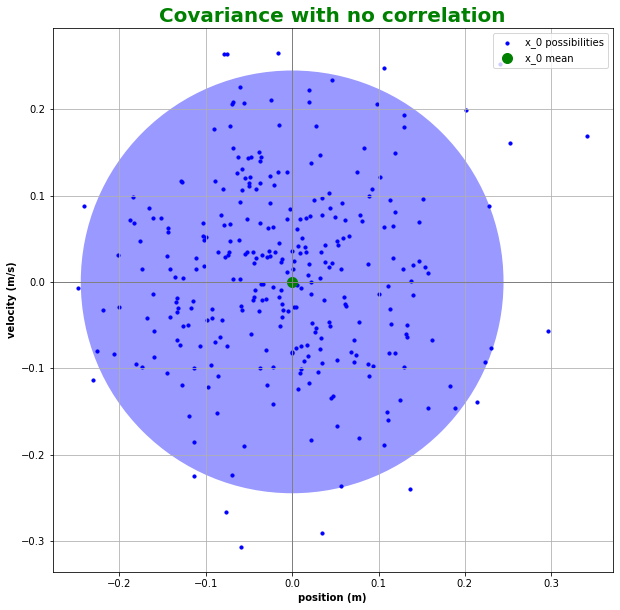

In [114]:
P = np.array([[0.1, 0.0], [0.0, 0.1]])

T = 1.0 # sampling time = 1 sec

P_0 = np.zeros((4, 4))
P_0[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
P_0[2:4,2:4] = np.array([[0.1, 0.0], [0.0, 0.1]])

F = np.array([[1., 0., 0., 0.],
              [0., 1., 0., 0.],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

P_1 = F @ P_0 @ F.T

P = np.zeros((2, 2))
P[0, 0] = P_1[0, 0]
P[0, 1] = P_1[0, 2]
P[1, 0] = P_1[2, 0]
P[1, 1] = P_1[2, 2]

example_covariance('Covariance with no correlation', P)

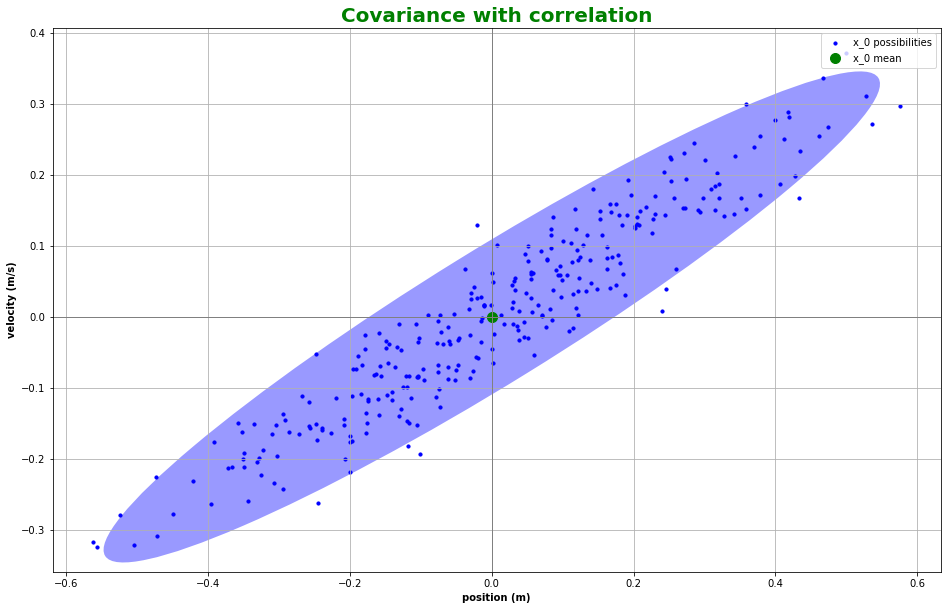

In [115]:
# propagating the previous state through the state transition matrix F_k
T = 1.0 # sampling time = 1 sec

P_0 = np.zeros((4, 4))
P_0[0:2,0:2] = np.array([[0.1, 0.0], [0.0, 0.1]])
P_0[2:4,2:4] = np.array([[0.1, 0.0], [0.0, 0.1]])

F = np.array([[1., 0., T, 0.],
              [0., 1., 0., T],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]])

P_1 = F @ P_0 @ F.T

P = np.zeros((2, 2))
P[0, 0] = P_1[0, 0]
P[0, 1] = P_1[0, 2]
P[1, 0] = P_1[2, 0]
P[1, 1] = P_1[2, 2]

example_covariance('Covariance with correlation', P)

## Update Step

We will assume that we know the initial position of the robot and also the velocity at that time.

$$
x_0 = \begin{bmatrix} p_x \\ v_x \end{bmatrix} = \begin{bmatrix} 0 \\ 2 \end{bmatrix}
$$

Since the velocity along x-axis isn't zero, so one can expect that the robot will move by 2 units along x-axis at the next cycle, given that the sample time is 1 second $T = 1 sec$.

We set the initial state covariance as follows:

$$
P_0 = \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix}
$$

Process noise:

$$
Q_k' =
\begin{bmatrix}
    q_{11}T+q_{33}\frac{T^3}{3} & q_{22} \frac{T^2}{2} \\
    q_{22} \frac{T^2}{2} & q_{22} T\\
\end{bmatrix}
$$

where;

$$
Q =
\begin{bmatrix}
    q_{11} & 0 \\
    0 & q_{22}
\end{bmatrix}
= 
\begin{bmatrix}
    0.1 & 0 \\
    0 & 0.1
\end{bmatrix}
$$

Prediction Model:

$$
F_k =
\begin{bmatrix}
    1 & T \\
    0 & 1
\end{bmatrix}
$$

Measurement:

$$
z =
\begin{bmatrix}
    2.25
\end{bmatrix}
$$


Measurement Noise:

$$
R =
\begin{bmatrix}
    0.01
\end{bmatrix}
$$

Measurement Model:

$$
H =
\begin{bmatrix}
    1 & 0
\end{bmatrix}
$$

Prediction step:

$$
x_{k|k-1} = F_k x_{k-1|k-1}
$$

$$
P_{k|k-1} = F_k P_{k-1|k-1} F_k^T + Q_k'
$$

Update step:

$$
\vec{z}_k - H_k \vec{x}_{k|k-1}
$$

$$
S_{k} = H_k P_{k|k-1} H_k^T + R_k
$$

$$
\vec{x}_{k|k} = \vec{x}_{k|k-1} + K_k (\vec{z}_k - H \vec{x}_{k|k-1})
$$

$$
P_{k|k} = (I - K_k H_k) P_{k|k-1}
$$

In [116]:
def predict(x, P, F, Q):
    x = F @ x
    P = F @ P @ F.T + Q
    return x, P

def correct(x, P, z, H, R):
    I = np.eye(len(P))
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.pinv(S)
    x = x + K @ (z - H @ x)
    P = (I - K @ H) @ P
    return x, P

x =  [[2.]
 [2.]]
P =  [[0.33333333 0.15      ]
 [0.15       0.2       ]]


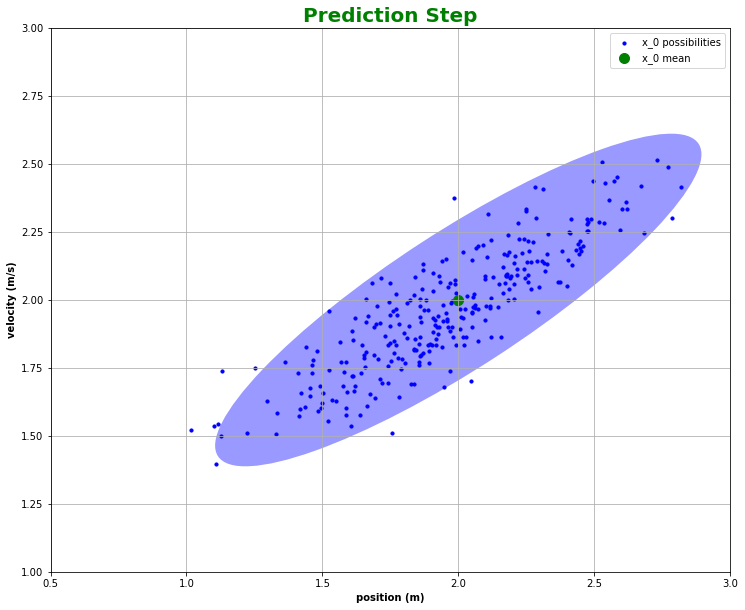

In [117]:
x = np.array([[0.], [2.]])
P = np.array([[0.1, 0.0], [0.0, 0.1]])

F = np.array([[1., T],
              [0., 1.]])

q_11 = q_33 = 0.1

Q = np.array([[q_11 * T + q_33 * (T**3/3), q_33 * (T**2/2)],
              [q_33 * (T**2/2), q_33 * T]])

x, P = predict(x, P, F, Q)

print('x = ', x)
print('P = ', P)


fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'aspect': 'equal'})

title = 'Prediction Step'
ax.set_title(title, fontsize=20, color='green', fontweight='bold')
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
ax.set_xlabel('position (m)', fontweight ='bold')
ax.set_ylabel('velocity (m/s)', fontweight ='bold')
ax.set_xlim(0.5, 3)
ax.set_ylim(1, 3)

plotData(ax, x, P, 10, 'b', 'x_0 possibilities')

ax.scatter(x[0], x[1], s=100.0, marker='o', c='green', label='x_0 mean')

plt.grid(visible=True)
plt.legend(loc='upper right')
plt.show()


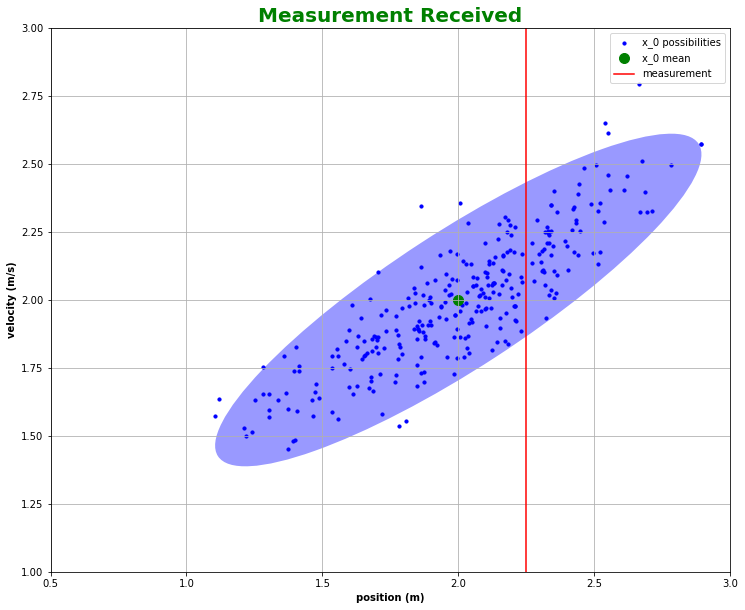

In [118]:
# a position measurement received
z = np.array([[2.25]])
R = np.array([[0.01]])
H = np.array([[1.0, 0.0]])


fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'aspect': 'equal'})

title = 'Measurement Received'
ax.set_title(title, fontsize=20, color='green', fontweight='bold')
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
ax.set_xlabel('position (m)', fontweight ='bold')
ax.set_ylabel('velocity (m/s)', fontweight ='bold')
ax.set_xlim(0.5, 3)
ax.set_ylim(1, 3)

plotData(ax, x, P, 10, 'b', 'x_0 possibilities')

ax.scatter(x[0], x[1], s=100.0, marker='o', c='green', label='x_0 mean') # prediction mean
ax.axvline(z[0], c='red', label='measurement') # measurement

plt.grid(visible=True)
plt.legend(loc='upper right')
plt.show()

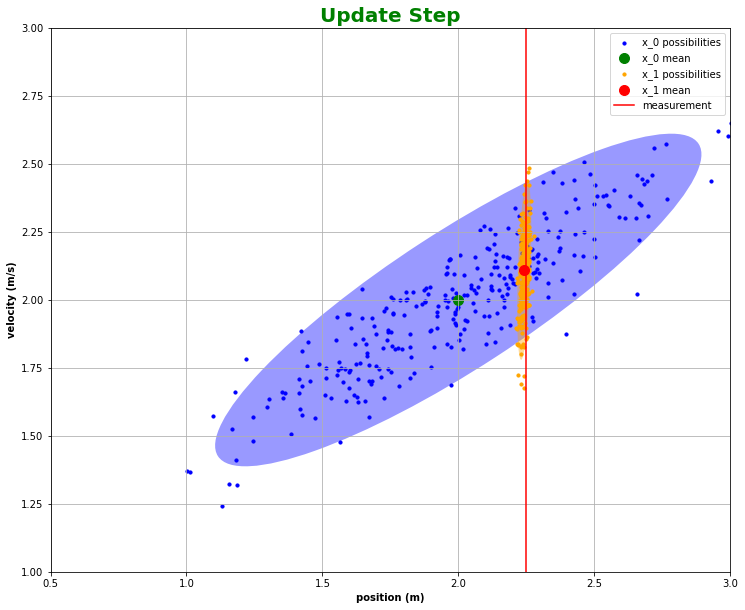

In [120]:
x = np.array([[0.], [2.]])
P = np.array([[0.1, 0.0], [0.0, 0.1]])

F = np.array([[1., T],
              [0., 1.]])

q_11 = q_33 = 0.1

Q = np.array([[q_11 * T + q_33 * (T**3/3), q_33 * (T**2/2)],
              [q_33 * (T**2/2), q_33 * T]])

x, P = predict(x, P, F, Q)

# a position measurement received
z = np.array([[2.25]])
R = np.array([[0.01]])
H = np.array([[1.0, 0.0]])

x1, P1 = correct(x, P, z, H, R)

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'aspect': 'equal'})

title = 'Update Step'
ax.set_title(title, fontsize=20, color='green', fontweight='bold')
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
ax.set_xlabel('position (m)', fontweight ='bold')
ax.set_ylabel('velocity (m/s)', fontweight ='bold')
ax.set_xlim(0.5, 3)
ax.set_ylim(1, 3)

plotData(ax, x, P, 10, 'blue', 'x_0 possibilities')
ax.scatter(x[0], x[1], s=100.0, marker='o', c='green', label='x_0 mean') # prediction mean

plotData(ax, x1, P1, 10, 'orange', 'x_1 possibilities')
ax.scatter(x1[0], x1[1], s=100.0, marker='o', c='red', label='x_1 mean') # prediction mean

ax.axvline(z[0], c='red', label='measurement') # measurement

plt.grid(visible=True)
plt.legend(loc='upper right')
plt.show()